**These code cells were run on google colab with GPU support.**

In [1]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


**Fetching the data**

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_openml("mnist_784")
print(mnist.keys())


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


**Plotting one example of each class**

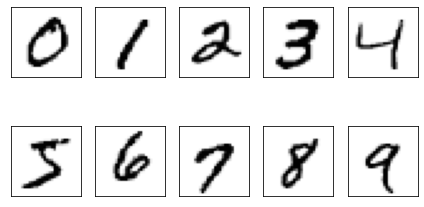

In [3]:
X = mnist["data"]
Y = mnist["target"]
Y = Y.astype(int)
X=(X/255 - 0.5)*2

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    for x, y in zip(X, Y):
        if y==i:
            img=np.array(x).reshape((28,28))
            ax[i].imshow(img, cmap="Greys")
            break
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

**Out of 70k examples, 10k will be used for test set, and remaining will be used for training and validation.**

In [4]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in split.split(X_train,Y_train):
    X_train_strat = X_train[train_index, :]
    Y_train_strat = Y_train[train_index]
    X_val_strat = X_train[val_index, :]
    Y_val_strat = Y_train[val_index]

In [6]:
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix


**Extending and overriding methods for our own dataset**

In [7]:

class mnist_dataset(data.Dataset):
    def label_transformer(self, labels):
        return labels

    def __init__(self, input_data, labels):
        input_data = input_data.reshape((len(input_data),1,28,28))
        self.feats = input_data
        self.labels = self.label_transformer(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        x = self.feats[index]
        y = self.labels[index]
        return x,y


**Creating dataloader for each of the train, validation, test dataset.**

In [8]:
class hyperparam:
    bs = 100
    lr = 0.05
    num_epochs = 50

params = {
    "batch_size": hyperparam.bs,
    "shuffle": True,
    "num_workers": 2,
    "drop_last": False,
    "pin_memory": True
}

train_set = mnist_dataset(X_train_strat, Y_train_strat)
val_set = mnist_dataset(X_val_strat, Y_val_strat)
test_set = mnist_dataset(X_test, Y_test)

training_gen = data.DataLoader(train_set, **params)
val_gen = data.DataLoader(val_set, **params)
test_gen = data.DataLoader(test_set, **params)

**Created a DNN with 2 layers of CNN with 12 filters each and adding two fully connected layers of 100 and 10 neurons respectively.
Used Relu activation function, with initial learning rate = 0.05 with glorot initialization. We have added Batch normalization2s layer before each CNN layer as well.**

In [9]:
from torch.nn import Conv2d, Linear, BatchNorm2d
from torch import flatten

class batch_cnn(nn.Module):
    
    def glorot_initialize(self, layers):
        
        for layer in layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
    
    def __init__(self):
        super(batch_cnn, self).__init__()
        self.batchn1 = BatchNorm2d(1)
        self.conv1 = Conv2d(1,12,kernel_size=(3,3), padding = 1)

        self.batchn2 = BatchNorm2d(12)
        self.conv2 = Conv2d(12,12,kernel_size=(3,3), padding = 1)
        self.fc1 = Linear(588, 100)
        self.fc2 = Linear(100, 10)
        
        self.glorot_initialize([self.conv1, self.conv2, self.fc1, self.fc2])
        
        
    def forward(self, sig):
        sig = self.batchn1(sig)
        sig = Func.max_pool2d(Func.relu(self.conv1(sig)), (2, 2))
        sig = self.batchn2(sig)
        sig = Func.max_pool2d(Func.relu(self.conv2(sig)), (2, 2))
        sig = sig.view(-1, 12*7*7)
        sig = Func.relu(self.fc1(sig))
        sig = self.fc2(sig)
        return sig
        # return Func.softmax(sig, dim = 1)

cnn_model = batch_cnn().to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = hyperparam.lr, momentum=0.9) # TODO ADAM optimizer
loss = nn.CrossEntropyLoss()

**Model is trained for 50 epochs, after each epochs, printing the validation accuracy. and resulting learning rate after adjusting learning rate by 10% each 10 epochs
Also using early stopping mechanism, which stops the learning if the validation accuracy starts dropping for a consecutive 5 cycles. This is done to prevent overfitting.**

In [10]:
from tqdm import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

tr_avg_loss_list = []
tr_accuracy_list = []
val_avg_loss_list = []
val_accuracy_list = []

print(datetime.now())

for epoch in tqdm(range(hyperparam.num_epochs)):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0
    val_num_correct = 0
    val_num_samples = 0
    val_total_loss = 0
    
    print("Learning rate: " + str(optimizer.param_groups[0]['lr']))

    cnn_model.train(True)
    with torch.set_grad_enabled(True):
        for ind, (local_batch, local_labels) in enumerate(training_gen):
            
            optimizer.zero_grad()
            local_batch = local_batch
            local_labels = local_labels
            local_batch, local_labels = Variable(local_batch).float(), Variable(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            out1 = cnn_model(local_batch)
            
            ploss = loss(out1, local_labels.long())
            tr_total_loss += ploss * hyperparam.bs
            ploss.backward()
            optimizer.step()
            sel_class = torch.argmax(out1, dim=1)
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
                
                                  
        tr_avg_loss = tr_total_loss / len(training_gen.dataset)
        tr_avg_loss_list.append(tr_avg_loss)
        tr_accuracy = tr_num_correct / len(training_gen.dataset)
        tr_accuracy_list.append(tr_accuracy)
    
    with torch.set_grad_enabled(False):
        cnn_model.eval()
        for local_batch, local_labels in val_gen:
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            out1 = cnn_model(local_batch)
            ploss = loss(out1, local_labels.long())
            val_total_loss += ploss * hyperparam.bs
            sel_class = torch.argmax(out1, dim=1)
            val_num_correct += sel_class.eq(local_labels).sum().item()
            val_num_samples += local_labels.size(0)

        val_avg_loss = val_total_loss / len(val_gen.dataset)
        val_avg_loss_list.append(val_avg_loss)
        val_accuracy = val_num_correct / len(val_gen.dataset)
        val_accuracy_list.append(val_accuracy)
        print("Validation accuracy: " + str(val_accuracy))

        scheduler.step()

        # Early stop
        if epoch > 10:
            if sum([val_accuracy_list[i] < val_accuracy_list[i-1] for i in range(epoch-5, epoch)]) == 5:
                break

        

  0%|          | 0/50 [00:00<?, ?it/s]

2021-04-11 08:12:56.083866
Learning rate: 0.05


  2%|▏         | 1/50 [00:03<02:32,  3.11s/it]

Validation accuracy: 0.9825
Learning rate: 0.05


  4%|▍         | 2/50 [00:05<02:22,  2.98s/it]

Validation accuracy: 0.9796666666666667
Learning rate: 0.05


  6%|▌         | 3/50 [00:08<02:16,  2.91s/it]

Validation accuracy: 0.9828333333333333
Learning rate: 0.05


  8%|▊         | 4/50 [00:11<02:11,  2.86s/it]

Validation accuracy: 0.985
Learning rate: 0.05


 10%|█         | 5/50 [00:14<02:08,  2.84s/it]

Validation accuracy: 0.9846666666666667
Learning rate: 0.05


 12%|█▏        | 6/50 [00:16<02:03,  2.80s/it]

Validation accuracy: 0.9868333333333333
Learning rate: 0.05


 14%|█▍        | 7/50 [00:19<01:59,  2.78s/it]

Validation accuracy: 0.9846666666666667
Learning rate: 0.05


 16%|█▌        | 8/50 [00:22<01:56,  2.76s/it]

Validation accuracy: 0.9838333333333333
Learning rate: 0.05


 18%|█▊        | 9/50 [00:24<01:53,  2.76s/it]

Validation accuracy: 0.9875
Learning rate: 0.05


 20%|██        | 10/50 [00:27<01:49,  2.73s/it]

Validation accuracy: 0.9861666666666666
Learning rate: 0.045000000000000005


 22%|██▏       | 11/50 [00:30<01:45,  2.72s/it]

Validation accuracy: 0.9861666666666666
Learning rate: 0.045000000000000005


 24%|██▍       | 12/50 [00:33<01:43,  2.73s/it]

Validation accuracy: 0.9855
Learning rate: 0.045000000000000005


 26%|██▌       | 13/50 [00:35<01:41,  2.73s/it]

Validation accuracy: 0.9866666666666667
Learning rate: 0.045000000000000005


 28%|██▊       | 14/50 [00:38<01:38,  2.73s/it]

Validation accuracy: 0.984
Learning rate: 0.045000000000000005


 30%|███       | 15/50 [00:41<01:34,  2.71s/it]

Validation accuracy: 0.986
Learning rate: 0.045000000000000005


 32%|███▏      | 16/50 [00:43<01:32,  2.73s/it]

Validation accuracy: 0.9871666666666666
Learning rate: 0.045000000000000005


 34%|███▍      | 17/50 [00:46<01:30,  2.73s/it]

Validation accuracy: 0.9826666666666667
Learning rate: 0.045000000000000005


 36%|███▌      | 18/50 [00:49<01:27,  2.74s/it]

Validation accuracy: 0.9866666666666667
Learning rate: 0.045000000000000005


 38%|███▊      | 19/50 [00:52<01:23,  2.70s/it]

Validation accuracy: 0.9855
Learning rate: 0.045000000000000005


 40%|████      | 20/50 [00:54<01:21,  2.71s/it]

Validation accuracy: 0.9861666666666666
Learning rate: 0.04050000000000001


 42%|████▏     | 21/50 [00:57<01:19,  2.75s/it]

Validation accuracy: 0.9865
Learning rate: 0.04050000000000001


 44%|████▍     | 22/50 [01:00<01:17,  2.75s/it]

Validation accuracy: 0.9881666666666666
Learning rate: 0.04050000000000001


 46%|████▌     | 23/50 [01:03<01:13,  2.74s/it]

Validation accuracy: 0.9881666666666666
Learning rate: 0.04050000000000001


 48%|████▊     | 24/50 [01:05<01:10,  2.72s/it]

Validation accuracy: 0.986
Learning rate: 0.04050000000000001


 50%|█████     | 25/50 [01:08<01:07,  2.70s/it]

Validation accuracy: 0.987
Learning rate: 0.04050000000000001


 52%|█████▏    | 26/50 [01:11<01:04,  2.68s/it]

Validation accuracy: 0.9866666666666667
Learning rate: 0.04050000000000001


 54%|█████▍    | 27/50 [01:13<01:01,  2.69s/it]

Validation accuracy: 0.9855
Learning rate: 0.04050000000000001


 56%|█████▌    | 28/50 [01:16<00:59,  2.70s/it]

Validation accuracy: 0.9858333333333333
Learning rate: 0.04050000000000001


 58%|█████▊    | 29/50 [01:19<00:56,  2.69s/it]

Validation accuracy: 0.987
Learning rate: 0.04050000000000001


 60%|██████    | 30/50 [01:21<00:53,  2.70s/it]

Validation accuracy: 0.9878333333333333
Learning rate: 0.03645000000000001


 62%|██████▏   | 31/50 [01:24<00:51,  2.70s/it]

Validation accuracy: 0.9886666666666667
Learning rate: 0.03645000000000001


 64%|██████▍   | 32/50 [01:27<00:48,  2.69s/it]

Validation accuracy: 0.9885
Learning rate: 0.03645000000000001


 66%|██████▌   | 33/50 [01:29<00:45,  2.67s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 68%|██████▊   | 34/50 [01:32<00:43,  2.69s/it]

Validation accuracy: 0.9898333333333333
Learning rate: 0.03645000000000001


 70%|███████   | 35/50 [01:35<00:40,  2.67s/it]

Validation accuracy: 0.9896666666666667
Learning rate: 0.03645000000000001


 72%|███████▏  | 36/50 [01:37<00:37,  2.68s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 74%|███████▍  | 37/50 [01:40<00:34,  2.68s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 76%|███████▌  | 38/50 [01:43<00:32,  2.69s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03645000000000001


 78%|███████▊  | 39/50 [01:46<00:29,  2.69s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03645000000000001


 80%|████████  | 40/50 [01:48<00:26,  2.68s/it]

Validation accuracy: 0.9891666666666666
Learning rate: 0.03280500000000001


 82%|████████▏ | 41/50 [01:51<00:24,  2.69s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


 84%|████████▍ | 42/50 [01:54<00:21,  2.70s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


 86%|████████▌ | 43/50 [01:56<00:19,  2.73s/it]

Validation accuracy: 0.9895
Learning rate: 0.03280500000000001


 88%|████████▊ | 44/50 [01:59<00:16,  2.74s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


 90%|█████████ | 45/50 [02:02<00:13,  2.78s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


 92%|█████████▏| 46/50 [02:05<00:11,  2.78s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


 94%|█████████▍| 47/50 [02:08<00:08,  2.79s/it]

Validation accuracy: 0.9895
Learning rate: 0.03280500000000001


 96%|█████████▌| 48/50 [02:10<00:05,  2.79s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


 98%|█████████▊| 49/50 [02:13<00:02,  2.76s/it]

Validation accuracy: 0.9896666666666667
Learning rate: 0.03280500000000001


100%|██████████| 50/50 [02:16<00:00,  2.73s/it]

Validation accuracy: 0.9895


**Plotting learning curves for validation and train dataset**

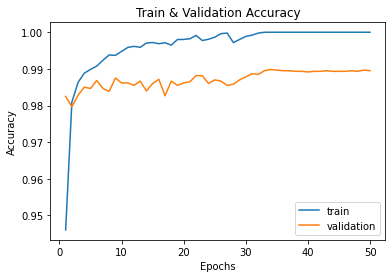

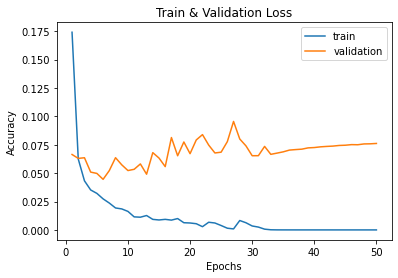

In [18]:
def plot_x_y_vals(x_vals, y_vals, x_label, y_label, label, line_titles):
    for i in range(len(x_vals)):
        plt.plot(x_vals[i], y_vals[i], label=line_titles[i])
    plt.title(label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

epocs = [i+1 for i in range(len(tr_accuracy_list))]
plot_x_y_vals([epocs, epocs], [tr_accuracy_list, val_accuracy_list], "Epochs", "Accuracy", "Train & Validation Accuracy", ["train", "validation"])
plot_x_y_vals([epocs, epocs], [tr_avg_loss_list, val_avg_loss_list], "Epochs", "Loss", "Train & Validation Loss", ["train", "validation"])

**Overfit or Underfit?**

The plot is very similar to baseline model. Part of the reason for this could be that the data we fed to our baseline model was already normalized, as we had changed the range of data to -1 to 1. 

Similar to baseline model,

In the above learning curves we see that, a very high accuracy on both training and validation set is observed. While the training accuracy is almost 1, the validation accuracy is very close to one, and is around ~0.99.

From the loss plot, we see that train loss is almost zero while validation loss, even though very less, has been increasing by very small amount each epoch in the end.

In the plot, even though plot looks to be diverging but since the scale is very small, the plots arent actually that far apart. However seeing almost 100% accuracy and slight increase in the validation loss, towards the end of the epochs, we can say that the model ever so slightly overfits, but still yields good results.


In [19]:
total_accurate = 0
total_values = 0
errors={i:{j:0 for j in range(10)} for i in range(10)}
incorrect_samples = []
correct_samples = []

def calculate_class_wise_errors(local_labels, sel_class, local_batch):
    true_labels = local_labels[sel_class.not_equal(local_labels)]
    predicted = sel_class[sel_class.not_equal(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[t.item()][p.item()] += 1
    
    true_labels = local_labels[sel_class.eq(local_labels)]
    predicted = sel_class[sel_class.eq(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[t.item()][p.item()] += 1

    if len(incorrect_samples) < 10:
        samples = local_batch[sel_class.not_equal(local_labels)]
        predicted = sel_class[sel_class.not_equal(local_labels)]
        true_labels = local_labels[sel_class.not_equal(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            incorrect_samples.append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

    if len(correct_samples) < 10:
        samples = local_batch[sel_class.eq(local_labels)]
        predicted = sel_class[sel_class.eq(local_labels)]
        true_labels = local_labels[sel_class.eq(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            correct_samples.append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

with torch.set_grad_enabled(False):
    cnn_model.eval()
    for local_batch, local_labels in test_gen:
        local_batch = local_batch.float()
        local_labels = local_labels.float()
        local_batch, local_labels = Variable(local_batch), Variable(local_labels)
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        out1 = cnn_model(local_batch)
        ploss = loss(out1, local_labels.long())
        sel_class = torch.argmax(out1, dim=1)
        calculate_class_wise_errors(local_labels, sel_class, local_batch)
        total_accurate += sel_class.eq(local_labels).sum().item()
        total_values += local_labels.size(0)

    

In [20]:
print("Predicted " + str(total_accurate) +" correctly out of " + str(total_values))


Predicted 9897 correctly out of 10000


**We see that on test set as well we have the accuracy almost equal to 99%, which is good. This also indicates that our model is good fit for data. Below we are plotting the heatmap, where y-axis represents the actual label and x-axis represents the predicted labels. Pleaase mind that all the diagonal elements have been set to zero. So the heatmap only represents the incorrectly classified label counts.**

**For example row = 4, col = 3 represents the count of images, which were 4, but were actually classified as 3. And the cell (4,4) is left empty, although it should ideally contain count of all the correctly classified images of 4. As this heatmap is generated only to see if there is any pair that is mistaken a lot in the classification OR if there is any bias in our model for any label.** 


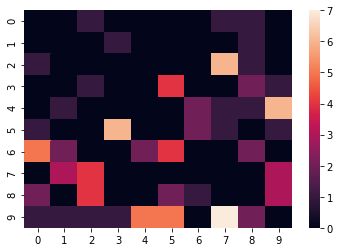

In [21]:
import seaborn as sns
class_acc = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        if i!=j:
            class_acc[i,j] = errors[i][j]
        else:
            class_acc[i,j] = 0

sns.heatmap(class_acc)
plt.show()

**Plotting few incorrectly classified images by our model. We see that these images are ambiguous and little bit hard to interpret or blurry. Each image contains the true value - predicted value pair on top of it.**

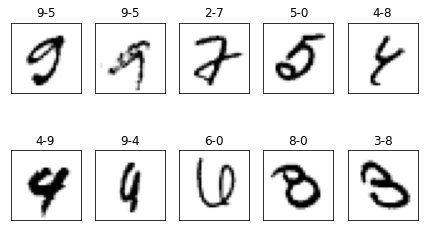

Incorrectly classified samples. (True and predicted values)


In [22]:

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img=np.array(incorrect_samples[i][0]).reshape(28,28)
    ax[i].imshow(img, cmap="Greys")
    ax[i].title.set_text(str(int(incorrect_samples[i][2])) + "-" + str(incorrect_samples[i][1]))
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

print("Incorrectly classified samples. (True and predicted values)")

**Plotting few correctly classified images by our model.**

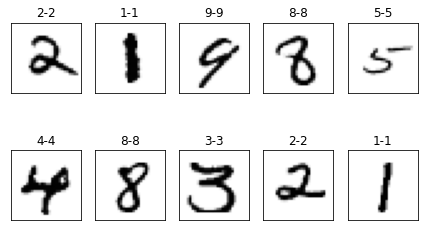

Correctly classified samples. (true and predicted values)


In [23]:

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img=np.array(correct_samples[i][0]).reshape(28,28)
    ax[i].imshow(img, cmap="Greys")
    ax[i].title.set_text(str(int(correct_samples[i][2])) + "-" + str(correct_samples[i][1]))
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

print("Correctly classified samples. (true and predicted values)")

**Plotting below confusion matrix for each class. By each class, we mean all the correct prediction fot that class = true positive. all the images of a class, that were incorrectly classfied as false negative. All the images, not of that class, but classified as of that class as false positive. And all the images that were not of a class and were also classified as not belonging to that class as true negative.**

In [24]:
import pandas as pd
# Confusion matrix
confusion_arr = np.zeros((10, 4))
for i in range(10):
    confusion_arr[i][0] = errors[i][i] # tp
    for j in range(10):
        if i!=j:
            confusion_arr[i][1]+=errors[j][i] # fp
    for j in range(10):
        if i!=j:
            confusion_arr[i][2]+= errors[i][j] # fn
    confusion_arr[i][3] = total_values - sum(confusion_arr[i][:3]) # tn

confusion_df = pd.DataFrame(confusion_arr, columns=["tp", "fp", "fn", "tn"])

confusion_df["precision"] = confusion_df["tp"] / (confusion_df["tp"] + confusion_df["fp"])
confusion_df["recall"] = confusion_df["tp"] / (confusion_df["tp"] + confusion_df["fn"])
confusion_df["accuracy"] = (confusion_df["tp"] + confusion_df["tn"]) / 10000

print("Overall Accuracy:" + str(total_accurate/total_values))

confusion_df


Overall Accuracy:0.9897


,tp,fp,fn,tn,precision,recall,accuracy
0,977.0,10.0,3.0,9010.0,0.989868,0.996939,0.9987
1,1133.0,7.0,2.0,8858.0,0.993860,0.998238,0.9991
2,1024.0,11.0,8.0,8957.0,0.989372,0.992248,0.9981
3,1002.0,8.0,8.0,8982.0,0.992079,0.992079,0.9984
4,971.0,7.0,11.0,9011.0,0.992843,0.988798,0.9982
5,881.0,15.0,11.0,9093.0,0.983259,0.987668,0.9974
6,943.0,5.0,15.0,9037.0,0.994726,0.984342,0.9980
7,1018.0,16.0,10.0,8956.0,0.984526,0.990272,0.9974
8,962.0,10.0,12.0,9016.0,0.989712,0.987680,0.9978
9,986.0,14.0,23.0,8977.0,0.986000,0.977205,0.9963


Conclusion:
We applied batch normalization two times, once in the beginning and once after first layer. While in the beginning, it did not have much effect, as the data was already almost normalized. The model performed almost similar to baseline. model. With accuracy also being almost similar to that of baseline model.

We see that a dropout layer works better then batch normalizaion in keeping the overfitting at bay and also while yielding better results.

We see that in batch normalization, the train accuracy is almost 100%, indicating a very small overfit. This wasnt the case for dropout layers. However batch normalization works a lot better for colored images, since our images werent colored the gains werent that noticeable. In colored images, the batch normalization, takes away the effect of bad lightings etc.

Another thing to note here is that, even after transforming the data for each batch, the accuracy of model isnt impacted. Which is counter-intutive. This means that same pixel can be transformed to a different value, depending on which sample is it in. Batch normalization, overall is also one of the option to make our model robest and slightly resilient to overfitting.